In [26]:
# Applying K-Nearest Neighbors: Predicting Car Prices
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
cars = pd.read_csv('Automobiles-Data1.csv')
cars.head(5)
test_cars = pd.read_csv('Automobiles-Testing1.csv')
test_cars.head(5)
# As you can see the data is a little messy. 

In [3]:
ordinal_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
test_ordinal_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']
car_features = cars[ordinal_values_cols]
test_car_features = test_cars[test_ordinal_values_cols]
test_car_features.head(5)
#When training a predictive model, it is important to not have any missing values. Based on the data set preview from the last step, I can tell that the normalized-losses column contains missing values represented using "?". 
#Let's replace these values and look for the presence of missing values in other numeric columns. Let's also normalize the values in all numeric columns so they have a value between zero and one. That way very large values will not have a greater influence, and everything will be relative.

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,103,104.3,188.8,67.2,56.2,2912,3.78,3.15,9.5,114,5400,23,28
1,74,104.3,188.8,67.2,57.5,3034,3.78,3.15,9.5,114,5400,23,28
2,95,109.1,188.8,68.9,55.5,2952,3.78,3.15,9.5,114,5400,23,28
3,95,109.1,188.8,68.8,55.5,3049,3.78,3.15,8.7,160,5300,19,25
4,95,109.1,188.8,68.9,55.5,3217,3.01,3.40,23.0,106,4800,26,27


In [4]:
#Replace all ? values with NaN values
car_features.replace('?', np.nan, inplace=True)
test_car_features.replace('?', np.nan, inplace=True)
#Make sure all values are type float
car_features = car_features.astype(float)
test_car_features = test_car_features.astype(float)
car_features.shape[0]
#test_car_features.shape[0]
test_car_features.head(5)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,103.0,104.3,188.8,67.2,56.2,2912.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
1,74.0,104.3,188.8,67.2,57.5,3034.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
2,95.0,109.1,188.8,68.9,55.5,2952.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
3,95.0,109.1,188.8,68.8,55.5,3049.0,3.78,3.15,8.7,160.0,5300.0,19.0,25.0
4,95.0,109.1,188.8,68.9,55.5,3217.0,3.01,3.40,23.0,106.0,4800.0,26.0,27.0


In [5]:
car_features = car_features.dropna(subset=['price'])
test_car_features.isnull().sum()
car_features.isnull().sum()
#Lets detemine how many rows have missing values and in which columns these missing values exist. 
#If it is a significant quantity, I might need to drop the column, otherwise I will just replace missing values with the average.

normalized-losses    33
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [6]:
car_features = car_features.fillna(car_features.mean())

test_car_features = test_car_features.fillna(test_car_features.mean())
test_car_features.isnull().sum()
car_features.isnull().sum()
#With those rows disposed off, I will replace any remaining null values with the mean value of their respective column.

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [7]:
test_car_features.head(5)
#Fantastic! No more missing data! Now it is time to normalise the data so that they all scale between 0 and 1. The only column I don't want to normalise it the price, as this is the label I will be using for my predictions.

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,103.0,104.3,188.8,67.2,56.2,2912.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
1,74.0,104.3,188.8,67.2,57.5,3034.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
2,95.0,109.1,188.8,68.9,55.5,2952.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
3,95.0,109.1,188.8,68.8,55.5,3049.0,3.78,3.15,8.7,160.0,5300.0,19.0,25.0
4,95.0,109.1,188.8,68.9,55.5,3217.0,3.01,3.40,23.0,106.0,4800.0,26.0,27.0


In [8]:
car_price = car_features['price']
features_labels = (car_features.max() - car_features)/(car_features.max())
test_features_labels = (test_car_features.max() - test_car_features)/(test_car_features.max())
features_labels['price'] = car_price
features_labels.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.520759,0.224168,0.154309,0.109722,0.183946,0.373340,0.086842,0.357314,0.608696,0.576336,0.242424,0.571429,0.500000,13495.0
1,0.520759,0.224168,0.154309,0.109722,0.183946,0.373340,0.086842,0.357314,0.608696,0.576336,0.242424,0.571429,0.500000,16500.0
2,0.520759,0.172504,0.142285,0.090278,0.123746,0.305706,0.294737,0.167866,0.608696,0.412214,0.242424,0.612245,0.518519,16500.0
3,0.359375,0.126095,0.115230,0.080556,0.091973,0.425234,0.160526,0.184652,0.565217,0.610687,0.166667,0.510204,0.444444,13950.0
4,0.359375,0.129597,0.115230,0.077778,0.091973,0.305460,0.160526,0.184652,0.652174,0.561069,0.166667,0.632653,0.592593,17450.0


In [9]:
#Univariant K-nearest Neighbours Model
def knn_train_test(df, feature_columns, label_columns,k_range):
    """Instantiate a K-nearest neighbours model and fit
    with data provided
    Keyword Arguments:
    df -- Pandas dataframe
    feature_columns -- columns containing feature elements
    label_columns -- columns containing labels
    k_range -- k values for knn parameters"""
    rmse_values = {}
    #Randomise the dataset
    np.random.seed(1)
    df = df.reindex(np.random.permutation(df.index))
    #Split the data evenly into test set and train set
    split_idx = int(df.shape[0]/2)
    train = df.iloc[0:split_idx]
    test = df.iloc[split_idx:]
    for k in k_range:
        #Instantiate the KNeighborsRegressor class
        knn = KNeighborsRegressor(n_neighbors=k)
        #Fit the model with our data
        knn.fit(train[feature_columns], train[label_columns])
        #Make predictions using the test features
        predictions = knn.predict(test[feature_columns])
        #Calculate the mean squared error of our prediction
        mse = mean_squared_error(test[label_columns], predictions)
        #Return the RMSE by taking the square root of the MSE
        rmse_values[k] = (np.sqrt(mse))
    return rmse_values

In [10]:
def knn_test_test(df, feature_columns, label_columns,k_range):
    """Instantiate a K-nearest neighbours model and fit
    with data provided
    Keyword Arguments:
    df -- Pandas dataframe
    feature_columns -- columns containing feature elements
    label_columns -- columns containing labels
    k_range -- k values for knn parameters"""
    rmse_values = {}
    #Randomise the dataset
    np.random.seed(1)
    df = df.reindex(np.random.permutation(df.index))
    #Split the data evenly into test set and train set
    split_idx = int(df.shape[0]/2)
    train = df.iloc[0:split_idx]
    test = df.iloc[split_idx:]
    for k in k_range:
        #Instantiate the KNeighborsRegressor class
        knn = KNeighborsRegressor(n_neighbors=k)
        #Fit the model with our data
        knn.fit(train[feature_columns], train[label_columns])
        #Make predictions using the test features
        predictions = knn.predict(test[feature_columns])
        #Calculate the mean squared error of our prediction
        mse = mean_squared_error(test[label_columns], predictions)
        #Return the RMSE by taking the square root of the MSE
        rmse_values[k] = (np.sqrt(mse))
    return rmse_values

In [11]:
feature_columns = features_labels.columns.drop('price')
column_rmse_values = {}
for col in feature_columns:
    column_rmse_values[col] = knn_train_test(features_labels,
                                            [col], 'price', 
                                            [1,3,5,7,9])
column_rmse_values

{'bore': {1: 9481.1992136404151,
  3: 5757.9835410057376,
  5: 5361.1053113215812,
  7: 5710.3612409573943,
  9: 5909.4782205677238},
 'city-mpg': {1: 7188.6602231985971,
  3: 5021.4753941545523,
  5: 4986.9912712747055,
  7: 5123.9541282373475,
  9: 5231.1129692560971},
 'compression-ratio': {1: 6759.8884512662789,
  3: 5906.2722861384973,
  5: 6096.9618366987443,
  7: 6482.9951960628923,
  9: 6483.8064172559589},
 'curb-weight': {1: 4806.8379622577559,
  3: 4001.5052878044467,
  5: 3816.4736356948702,
  7: 3838.0740826730175,
  9: 3990.2458885600909},
 'height': {1: 11794.151313549295,
  3: 7558.1100147385678,
  5: 7114.9779592715213,
  7: 7238.7268355763945,
  9: 7130.6231584572452},
 'highway-mpg': {1: 7018.9964366005697,
  3: 4321.8811984170925,
  5: 4145.1398783436107,
  7: 4341.0221853984467,
  9: 4471.6696534958555},
 'horsepower': {1: 3953.7516215687438,
  3: 4486.1206635486587,
  5: 4780.2902159770083,
  7: 4737.8036056415249,
  9: 4813.8075693365599},
 'length': {1: 5365.131

<function matplotlib.pyplot.show>

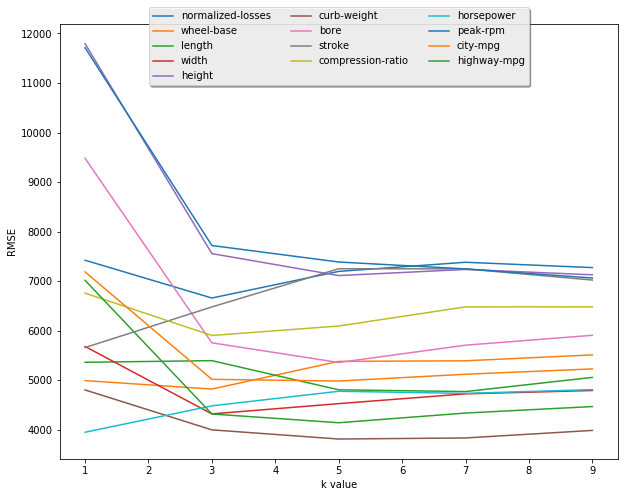

In [12]:

fig = plt.figure(figsize=(10,8))
for k,v in column_rmse_values.items():
    ax = plt.subplot(111)
    sorted_rmse = sorted(column_rmse_values[k].items())
    x, y = zip(*sorted_rmse)
    ax.plot(x,y, label = k)
ax.set_xlabel('k value')
ax.set_ylabel('RMSE')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show

In [13]:
#The plot above shows that an optimum k value exists above 3, and the safest bet would be around a value of 5. 
#The columns with the lowest error are 'Horsepower', 'width', 'curb-weight', 'highway-mpg', and 'length'. 
#This is possibly suggesting how well known measures of performance, miles per gallon and horsepower, have a powerful influence over price. The other attribute is the size of the vehicle.
four_best_features = ['horsepower', 'width', 'curb-weight', 'highway-mpg']

In [14]:
k = 5
rmse_results = {}

In [15]:
#I will now increase the number of features and then plot the results to find the optimum number of features to use
two_best_features = ['horsepower', 'highway-mpg']
three_best_features = ['horsepower', 'width', 'highway-mpg']
four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse = knn_train_test(features_labels, two_best_features, 'price',[k])
rmse_results[2] = rmse[5]
rmse = knn_train_test(features_labels, three_best_features, 'price',[k])
rmse_results[3] = rmse[5]
rmse = knn_train_test(features_labels, four_best_features, 'price',[k])
rmse_results[4] = rmse[5]
rmse = knn_train_test(features_labels, five_best_features, 'price',[k])
rmse_results[5] = rmse[5]
rmse = knn_train_test(features_labels, six_best_features, 'price',[k])
rmse_results[6] = rmse[5]
rmse_results


{2: 3998.7089176727859,
 3: 3741.5570500903045,
 4: 3604.4686841076373,
 5: 3766.3635492113058,
 6: 3779.3328546460289}

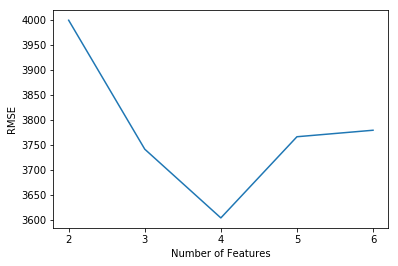

In [16]:
y = [v for k,v in rmse_results.items()]
x = np.arange(2,7,1)
plt.plot(x,y)
plt.xticks(x)
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.show()

In [17]:
#From the graph above it is clear that the optimum number of features is 4. 
#I will now vary the k value between 1 and 25 for both these features and then plot the results to find the optimum model
k = np.arange(1,26,1)
rmse_values_three = knn_train_test(features_labels, three_best_features, 'price',k)
rmse_values_four = knn_train_test(features_labels, four_best_features, 'price',k)

<function matplotlib.pyplot.show>

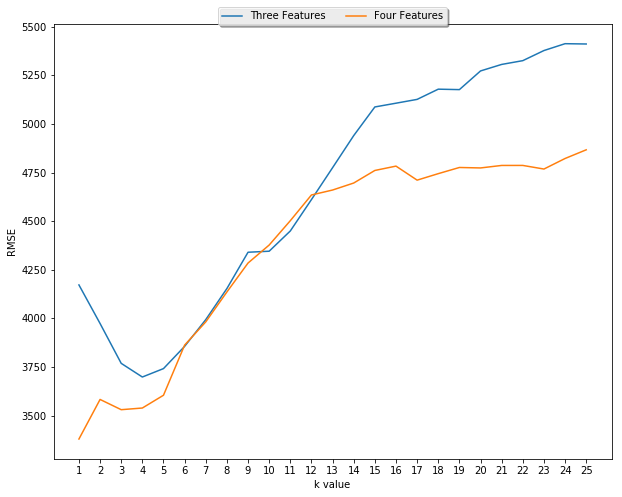

In [18]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
y = [v for k,v in rmse_values_three.items()]
x = k
ax.plot(x,y, label = 'Three Features')
y = [v for k,v in rmse_values_four.items()]
x = k
ax.plot(x,y, label = 'Four Features')
ax.set_xticks(np.arange(min(k), max(k)+1, 1.0))
ax.set_xlabel('k value')
ax.set_ylabel('RMSE')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show

In [19]:
#K-Fold Cross Validation
kf = KFold(n_splits=5,shuffle=True,random_state=1)
knn = KNeighborsRegressor(n_neighbors=1)
mses = cross_val_score(knn,features_labels[four_best_features],features_labels['price'],scoring='neg_mean_squared_error',cv=kf)
avg_rmses = np.mean([(np.abs(mse)**(1/2)) for mse in mses])

avg_rmses

2479.32892133938

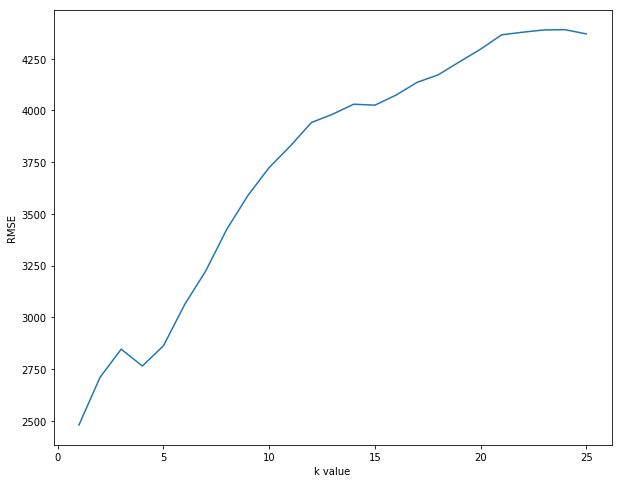

In [20]:
#Interestingly the RMSE was higher than observed when using test/train validation. This might demonstrate that some bias was being made towards the fixed training set I was using. 
#Lets use cross validation to see what the optimum k value is when using the four feature model:
k_vals = np.arange(1,26,1)
avg_rmses= {}
for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k)
    mses = cross_val_score(knn,features_labels[four_best_features],features_labels['price'],scoring='neg_mean_squared_error',cv=kf)
    avg_rmses[k] = np.mean([(np.abs(mse)**(1/2)) for mse in mses])
    
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
y = [v for k,v in avg_rmses.items()]
x = k_vals
ax.set_xlabel('k value')
ax.set_ylabel('RMSE')
ax.plot(x,y)
plt.show()

In [21]:
#Lets predict the test data 
knn = KNeighborsRegressor(n_neighbors=1)
#Fit the model with our data
knn.fit(features_labels[four_best_features],features_labels['price'])
#Make predictions using the test features
predictions = knn.predict(test_features_labels[four_best_features])

In [22]:
test_features_labels['price'] = predictions

In [47]:
#Save the predictions to the CSV
test_features_labels.to_csv('out.csv')